## ЛЕГЕНДА

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы.

Стоимость туров:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

Проверьте, какая из страниц приносит больше покупок.

## ЗАДАЧИ

1. Провести первичный анализ датасета.
В рамках этой задачи вам предстоит:
    * привести столбцы к корректным типам данных;
    * убедиться, что данные по обеим группам представлены за одинаковый период (визуализировать);
    * проверить корректность распределения участников теста;
    * проверить различие в группах;
    * проверить пересечение аудитории в группах;
    * определить по группам ряд показателей (количество пользователей, количество покупок, выручку, конверсию, средний чек);
    * посмотреть, как распределяются суммы покупок (здесь необходимо повизуализировать);
    * сделать первичные выводы.
2. Рассчитайте кумулятивные метрики:
    * постройте график конверсии в группах по дням;
    * постройте график среднего чека в группах по дням;
    * постройте график кумулятивных метрик по конверсии и по среднему чеку;
сделайте выводы.
3. Проведите статистическую проверку гипотез:
    * о равенстве конверсии;
    * о равенстве выручки;
    * о равенстве средних чеков по дням.
4. Сделайте вывод.

In [155]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math as mth

In [156]:
# прочитаем файл
df = pd.read_csv('ab_data.csv')

In [157]:
# выведем 5 строк таблицы
df.head()


,Unnamed: 0,user_id,date,group,purchase,price
0,0,851104,2021-01-21,A,0,0
1,1,804228,2021-01-12,A,0,0
2,2,661590,2021-01-11,B,0,0
3,3,853541,2021-01-08,B,0,0
4,4,864975,2021-01-21,A,1,150000


In [158]:
# изучим таблицу
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  294478 non-null  int64 
 1   user_id     294478 non-null  int64 
 2   date        294478 non-null  object
 3   group       294478 non-null  object
 4   purchase    294478 non-null  int64 
 5   price       294478 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.5+ MB


In [159]:
# приведем дату к нужному формату
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [160]:
# изучим данные
print(df['date'].min())
print(df['date'].max())

2021-01-02 00:00:00
2021-01-24 00:00:00


In [161]:
df.describe(include=['datetime64'])

<ipython-input-161-2d34eebdf913>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include=['datetime64'])


,date
count,294478
unique,23
top,2021-01-08 00:00:00
freq,13564
first,2021-01-02 00:00:00
last,2021-01-24 00:00:00


In [162]:
# количество посещений сайта в группах А и В
df_piv = df.groupby(['group']).agg({'user_id':'count'}).reset_index()
df_piv

,group,user_id
0,A,147202
1,B,147276


In [163]:
# Какая разница в процентном выражении между группами? Удовлетворяет ли она условию, что разница не должна быть больше 1%?
(df_piv.loc[0,'user_id']/df_piv.loc[1,'user_id']-1)*100

-0.050245797006975845

In [164]:
# есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей?
user_a = set(df[df['group'] == 'A']['user_id'].unique())
user_b = set(df[df['group'] == 'B']['user_id'].unique())
user_double = set(user_a.intersection(user_b))
len(user_double)

1895

In [165]:
# Список пользователей, с удаленными дублями и фильтрация по списку
user_c = set(df['user_id'].unique())
user_unique = user_c.difference(user_double)
df = df[df['user_id'].isin(user_unique)] 

In [166]:
# количество посещений сайта в группах А и В (после удаления дублей)
df_piv = df.groupby(['group']).agg({'user_id':'count'}).reset_index()
df_piv

,group,user_id
0,A,145307
1,B,145381


In [167]:
# Какая разница в процентном выражении между группами? Удовлетворяет ли она условию, что разница не должна быть больше 1%?
(df_piv.loc[0,'user_id']/df_piv.loc[1,'user_id']-1)*100

-0.050900736684988956

С помощью метода groupby соберите таблицу   
где user_id — количество пользователей в группе; purchase — количество покупок в группе; price — сумма всех покупок в группе. 
В получившуюся таблицу добавьте показатели конверсии и среднего чека по каждой группе.

In [168]:
df_piv = df.groupby(['group']).agg({'user_id':'count', 'purchase': 'sum', 'price': 'sum'}).reset_index()
df_piv['conversion'] = df_piv['purchase'] / df_piv['user_id']
df_piv['avg_chek'] = df_piv['price'] / df_piv['purchase']
df_piv

,group,user_id,purchase,price,conversion,avg_chek
0,A,145307,17487,1417780000,0.120345,81076.228055
1,B,145381,17290,1533010000,0.118929,88664.545980


Несмотря на то что в группе B было больше посетителей, (относительная) конверсия в группе B меньше на 1.16%. За счёт меньшей конверсии в группе B было меньше покупок, однако выручка группы B больше выручки группы A на 115230000 единиц, или 7.5%. Большая выручка в группе B складывается за счёт того, что средний чек группы B выше среднего чека группы A. верно

<AxesSubplot:>

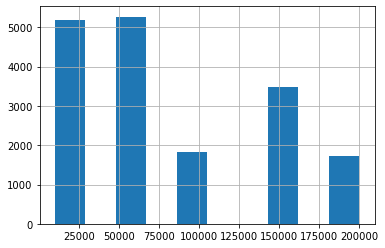

In [169]:
df[(df['group'] == 'A') & (df['purchase'] > 0)]['price'].hist()

<AxesSubplot:>

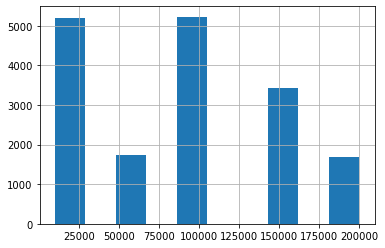

In [170]:
df[(df['group'] == 'B') & (df['purchase'] > 0)]['price'].hist()

Создайте кумулятивную таблицу  
Есть несколько способов создать кумулятивную таблицу.

Воспользуйтесь одним из них и создайте кумулятивную таблицу для каждой из групп, так чтобы в ней были представлены следующие данные:
* дата;
* количество пользователей (кумулятивное);
* bколичество заказов (кумулятивное);
* выручка (кумулятивная).

In [171]:
dfa_piv = df[df['group'] == 'A'].groupby(['date', 'group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index()
dfb_piv = df[df['group'] == 'B'].groupby(['date', 'group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index()

In [172]:
def cummulative_table(data): # В переменную data будем передавать название переменной датафейма
    df_cumm = [] # Создаём пустой список
    for i in data['date'].values: # Запускаем цикл по каждому отдельному значению даты
        out = data[data['date'] <= i].groupby('group').agg({'date':'max', 'user_id':'sum', 'purchase':'sum', 'price':'sum'})
        df_cumm.append(out) # Полученный срез добавляем в созданный ранее список
    return pd.concat(df_cumm).reset_index() # Объединяем списки и возвращаем результат

In [173]:
cumm_a = cummulative_table(dfa_piv)
cumm_b = cummulative_table(dfb_piv)

In [174]:
# Из получившихся таблиц рассчитайте средний чек и конверсию на каждый день
cumm_a['conversion'] = cumm_a['purchase'] / cumm_a['user_id']
cumm_b['conversion'] = cumm_b['purchase']/ cumm_b['user_id']

cumm_a['avg_chek'] = cumm_a['price'] / cumm_a['purchase']
cumm_b['avg_chek'] = cumm_b['price'] / cumm_b['purchase']

In [175]:
# Какая суммарная выручка была в группе А на 15 января?
cumm_a[cumm_a['date'] == '2021-01-15']['price']

13    865120000
Name: price, dtype: int64

In [176]:
# Какая кумулятивная конверсия была в группе B на 20 января?
cumm_b[cumm_b['date'] == '2021-01-20']['conversion']

18    0.118959
Name: conversion, dtype: float64

In [177]:
# Какой кумулятивный средний чек был в группе А на 12 января?
cumm_a[cumm_a['date'] == '2021-01-12']['avg_chek']

10    81491.827275
Name: avg_chek, dtype: float64

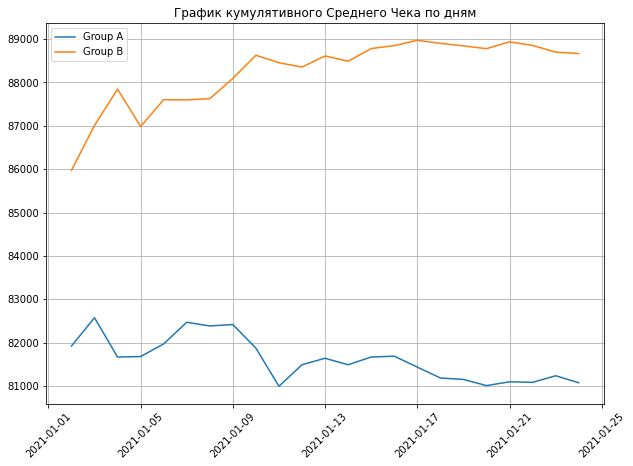

In [178]:
plt.figure(figsize=(10,7))
plt.plot(cumm_a['date'], cumm_a['avg_chek'], label='Group A')
plt.plot(cumm_b['date'], cumm_b['avg_chek'], label='Group B')
plt.title('График кумулятивного Среднего Чека по дням')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()

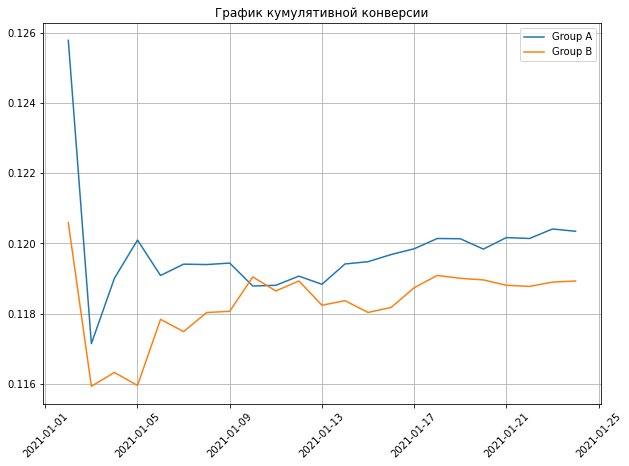

In [179]:
plt.figure(figsize=(10,7))
plt.plot(cumm_a['date'], cumm_a['conversion'], label='Group A')
plt.plot(cumm_b['date'], cumm_b['conversion'], label='Group B')
plt.title('График кумулятивной конверсии')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()

#### Проверьте распределение показателей конверсии в группах

<AxesSubplot:>

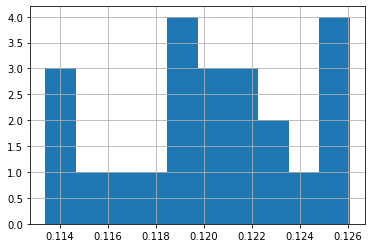

In [180]:
dfa_piv['conversion'] = dfa_piv['purchase'] / dfa_piv['user_id']
dfa_piv['avg_chek'] = dfa_piv['price'] / dfa_piv['purchase']
dfa_piv['conversion'].hist()

<AxesSubplot:>

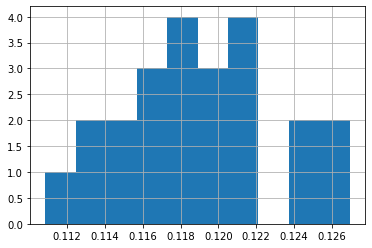

In [181]:
dfb_piv['conversion'] = dfb_piv['purchase'] / dfb_piv['user_id']
dfb_piv['avg_chek'] = dfb_piv['price'] / dfb_piv['purchase']
dfb_piv['conversion'].hist()

Проведите выбранный тест с уровнем статистической значимости, равным 0.05

In [182]:
a = .05
x1 = dfa_piv['purchase'].sum()
x2 = dfb_piv['purchase'].sum()
n1 = dfa_piv['user_id'].sum()
n2 = dfb_piv['user_id'].sum()
p1 = x1 / n1
p2 = x2 / n2
p = (x1 + x2) / (n1 + n2)
diff = p1 - p2
z = diff / mth.sqrt(p * (1 - p) * (1/n1 + 1/n2))
z

1.176469036591924

In [184]:
distr = st.norm(0, 1)
p_val = (1 - distr.cdf(abs(z))) * 2
p_val

0.23940749849829834

P-value больше принятого уровня значимости, следовательно, статистически значимая разница между конверсиями отсутствует.

#### Проверьте различия в стоимости заказов между группами

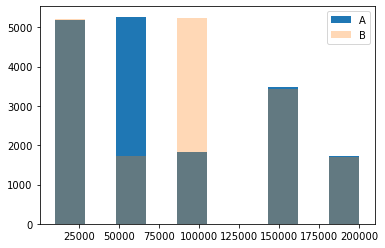

In [185]:
# Постройте гистограмму стоимости покупок
plt.hist(df[(df['group'] == 'A') & (df['purchase'] > 0)]['price'], label='A')
plt.hist(df[(df['group'] == 'B') & (df['purchase'] > 0)]['price'], label='B', alpha=0.3)
plt.legend() 
plt.show() 

In [189]:
# Запишем стоимость заказа в различны переменные:
price_a = df[(df['group'] == 'A') & (df['purchase'] > 0)]['price']
price_b = df[(df['group'] == 'B') & (df['purchase'] > 0)]['price']

In [190]:
# Зададим уровень значимости и применим теста Манна-Уитни:
alpha = .05
results = st.mannwhitneyu(price_a, price_b)
print(results)

MannwhitneyuResult(statistic=139547139.0, pvalue=1.412680672643368e-37)


In [191]:
results.pvalue < alpha

True

Статистически значимая разница есть. Нулевая гипотеза не верна. Похоже, что средняя стоимость заказов различается

####  Проверьте различие средних чеков по дням

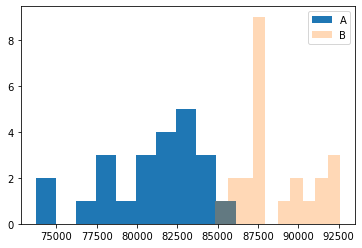

In [194]:
# Постройте гистограмму среднего чека
plt.hist(dfa_piv['avg_chek'], label='A')
plt.hist(dfb_piv['avg_chek'], label='B', alpha=0.3)
plt.legend() 
plt.show() 

<AxesSubplot:>

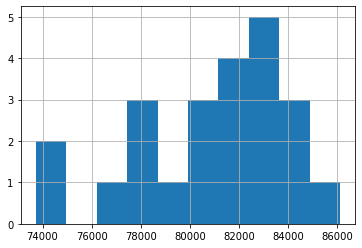

In [195]:
dfa_piv['avg_chek'].hist()

<AxesSubplot:>

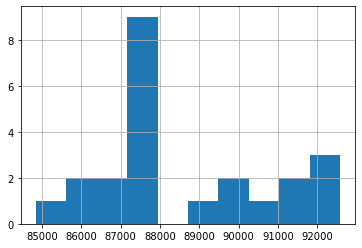

In [196]:
dfb_piv['avg_chek'].hist()

In [204]:
print(dfa_piv['avg_chek'].mean())
print(dfb_piv['avg_chek'].mean())

80969.2850990052
88575.71551361022


In [211]:
c = df['price'].sum()/df['purchase'].sum()
a = dfa_piv['price'].sum()/dfa_piv['purchase'].sum()
b = dfb_piv['price'].sum()/dfb_piv['purchase'].sum()
print(a)
print(b)
print(c)

81076.22805512666
88664.54598033546
84848.89438421946


In [214]:
alpha = .05
t_test = st.ttest_1samp(dfb_piv['avg_chek'], c)
print('pvalue: ', t_test.pvalue / 2)

if (t_test.pvalue / 2 < alpha) and (b > c):
   print("Отвергаем нулевую гипотезу")
else:
   print("Не отвергаем нулевую гипотезу")

pvalue:  2.225462280138656e-08
Отвергаем нулевую гипотезу


**Общий вывод по результату A/B-тестирования**  
Несмотря на то что конверсия группы B ниже, статистической значимости в конверсии не достигнуто, соответственно, считать конверсии разными оснований нет. Зато средний чек группы B значительно выше среднего чека группы A. Статистическая значимость достигнута. Вариант сайта B приносит значимо больше выручки, чем вариант сайта A. Рекомендуем признать, что вариант B лучше, чем вариант A! верно